# Livrable 3 - Captionning

Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Dany KHADHAR
- Romaric DEMBELE

## Contexte

Ce livrable marque l'achèvement de notre processus de traitement. Notre objectif est de développer un réseau de neurones capable de générer des légendes pour des images, en utilisant le dataset MS COCO comme base. Le réseau se compose de deux éléments principaux : une partie Convolutional Neural Network (CNN) qui encode les images en une représentation interne, et une partie Recurrent Neural Network (RNN) qui utilise cette représentation pour prédire la légende de l'image, séquence par séquence. Avant l'entraînement du modèle, les images sont prétraitées par un CNN pré-entraîné pour la classification.

## 1. Imports

Nous commencons par importer les différentes librairies nécessaires.

In [132]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

## 2. Chargement des données

Dans ce segment de code, nous préparons notre ensemble de données pour l'entraînement de notre modèle de génération de légendes. Nous commençons par définir les chemins vers le fichier d'annotations et le dossier contenant les images à annoter. Ensuite, nous lisons le fichier d'annotations et regroupons toutes les annotations ayant la même image comme identifiant. Pour chaque annotation, nous marquons le début et la fin de chaque légende et ajoutons cette légende à la liste des légendes associées à l'image correspondante. Nous limitons ensuite notre ensemble de données aux 2000 premières images. Enfin, nous créons deux listes : une contenant toutes les légendes et une autre contenant les noms des fichiers images, chaque path étant répété autant de fois qu'il y a de légendes associées à cette image. Ces listes seront utilisées pour l'entraînement de notre modèle.

In [133]:
# Chemin du fichier d'annotations
annotation_folder = "/dataset_livrable_3/annotations/"
annotation_file = os.path.abspath('.')+"/dataset_livrable_3/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
image_folder = '/dataset_livrable_3/train2014/'
PATH = os.path.abspath('.') + image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>" 
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption) 
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list) 
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list)) 

Vérifions désormais si chaque annotations comprends bien une image qui lui ai associée.

In [134]:
print(len(train_captions))
print(len(img_name_vector))

10005
10005


Dans le cadre de notre analyse, nous allons maintenant visualiser les neuf premières images de notre ensemble de données, accompagnées de leurs annotations respectives. Pour ce faire, nous avons regroupé les légendes par chemin d'image à l'aide d'un dictionnaire. Ensuite, nous parcourons ce dictionnaire et pour chaque image, nous affichons l'image elle-même suivie de toutes ses légendes correspondantes. Cette visualisation nous permet d'avoir une meilleure compréhension des données sur lesquelles nous travaillons.

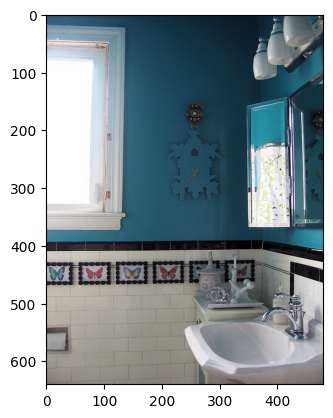

<start> A very clean and well decorated empty bathroom <end>
<start> A blue and white bathroom with butterfly themed wall tiles. <end>
<start> A bathroom with a border of butterflies and blue paint on the walls above it. <end>
<start> An angled view of a beautifully decorated bathroom. <end>
<start> A clock that blends in with the wall hangs in a bathroom.  <end>


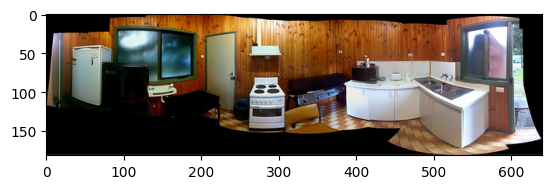

<start> A panoramic view of a kitchen and all of its appliances. <end>
<start> A panoramic photo of a kitchen and dining room <end>
<start> A wide angle view of the kitchen work area <end>
<start> multiple photos of a brown and white kitchen.  <end>
<start> A kitchen that has a checkered patterned floor and white cabinets. <end>


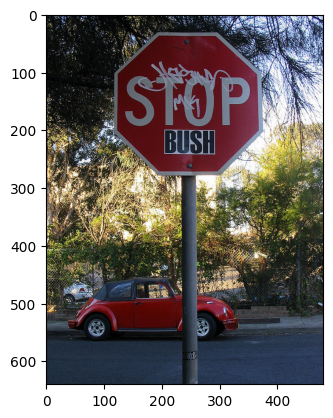

<start> A graffiti-ed stop sign across the street from a red car  <end>
<start> A vandalized stop sign and a red beetle on the road <end>
<start> A red stop sign with a Bush bumper sticker under the word stop. <end>
<start> A stop sign that has been vandalized is pictured in front of a parked car. <end>
<start> A street sign modified to read stop bush. <end>


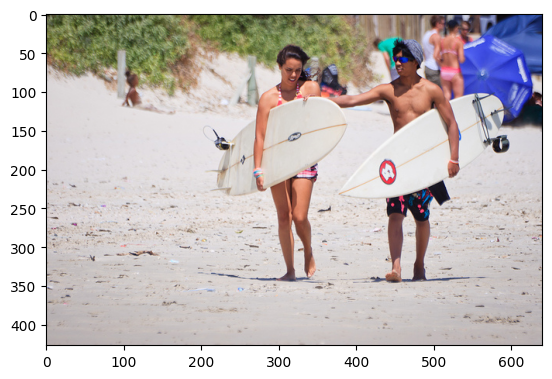

<start> The two people are walking down the beach. <end>
<start> Two people carrying surf boards on a beach. <end>
<start> Two teenagers at a white sanded beach with surfboards. <end>
<start> A couple at the beach walking with their surf boards. <end>
<start> A guy and a girl are walking on the beach holding surfboards. <end>


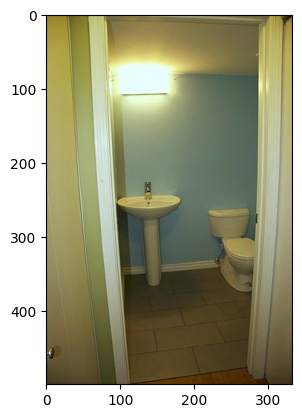

<start> A sink and a toilet inside a small bathroom. <end>
<start> White pedestal sink and toilet located in a poorly lit bathroom. <end>
<start> Clean indoor bathroom with tiled floor and good lighting. <end>
<start> a bathroom with toilet and sink and blue wall <end>
<start> a blue bathroom with a sink and toilet <end>


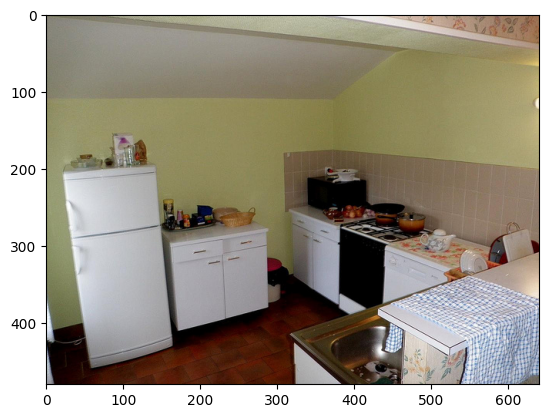

<start> An empty kitchen with white and black appliances. <end>
<start> A refrigerator and stove are in a small kitchen area.  <end>
<start> Small kitchen in a personal home with dual sinks. <end>
<start> A small kitchen with sink, stove and refrigerator. <end>
<start> A small kitchen with several appliances and cookware. <end>


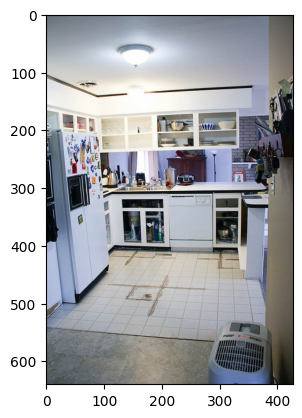

<start> A white square kitchen with tile floor that needs repairs  <end>
<start> A white kitchen in a home with the light on. <end>
<start> A kitchen with a tile floor has cabinets with no doors, a dishwasher, a sink, and a refrigerator. <end>
<start> A white kitchen without doors on the cabinets. <end>
<start> A white kitchen filled with pots, pans and dishes. <end>


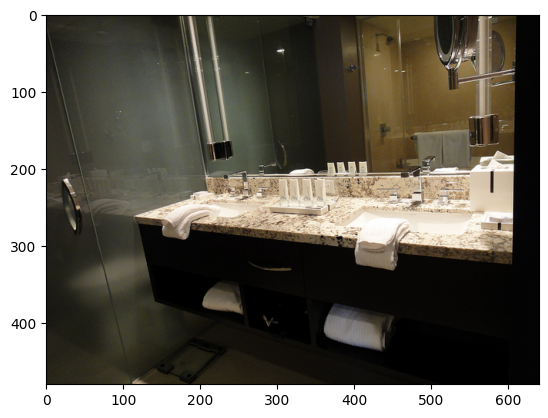

<start> The vanity contains two sinks with a towel for each. <end>
<start> A clean restroom with towels and washcloths laid out. <end>
<start> The bathroom counter is stocked with towels and supplies. <end>
<start> There is a clean bathroom counter and sink. <end>
<start> A hotel bathroom with stone counter and mirror <end>


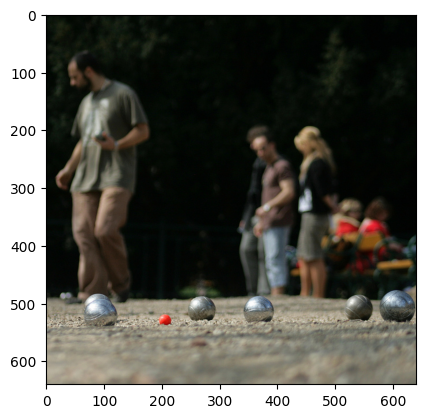

<start> Several metal balls sit in the sand near a group of people. <end>
<start> People standing around many silver round balls on the ground. <end>
<start> Silver balls are lined up in the sand as people mill about in the background. <end>
<start> Silver balls on sand with people walking around.  <end>
<start> silver balls laying on the ground around a smaller red ball.  <end>


In [135]:
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image

# Créer un dictionnaire pour regrouper les légendes par chemin d'image
captions_by_image = defaultdict(list)
for img_path, caption in zip(img_name_vector, train_captions):
    captions_by_image[img_path].append(caption)

# Afficher les 9 premières images avec toutes leurs légendes
images_displayed = 0
for img_path, captions in captions_by_image.items():
    if images_displayed < 9:
        image = Image.open(img_path)
        plt.imshow(image)
        plt.show()

        # Afficher toutes les légendes pour cette image
        for caption in captions:
            print(caption)
        images_displayed += 1
    else:
        break

## 3. Pré-traitement des images



Dans ce livrable, nous accordons une importance au prétraitement des images. Cette étape, qui comprend le redimensionnement des images, la normalisation des pixels et l'application de transformations, prépare nos données pour un traitement efficace et optimise les performances du modèle. Nous utilisons le modèle InceptionV3, pré-entraîné sur ImageNet, pour extraire des caractéristiques pertinentes de nos images. Cela nous permet de convertir nos images en un format adapté à notre modèle de captioning, tout en conservant les informations visuelles essentielles. Cette approche s'appelle "transfer learning", où nous exploitons les connaissances d'un modèle pour résoudre une autre tâche.

### Télechargement du modèle InceptionV3

Dans cette partie, nous commençons par télécharger le modèle pré-entraîné InceptionV3. Nous utilisons ce modèle pour extraire les caractéristiques des images. Nous créons un nouveau modèle qui prend en entrée une image et produit une représentation dense de celle-ci.

Ensuite, nous définissons une fonction `load_image` qui prend le chemin d'une image, charge l'image, la décode en RGB, la redimensionne à une taille de (299, 299) et normalise ses pixels entre -1 et 1.

In [136]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = \
    image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = \
    image_model.layers[-1].output
# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
# Définition de la fonction load_image
def load_image(image_path):
    img = \
        tf.io.read_file(image_path)
    img = \
        tf.image.decode_jpeg(img, channels=3)
    img = \
        tf.image.resize(img, (299, 299)) 
    img = \
        tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Extraction et sauvegarde des caractéristiques d'images avec InceptionV3

Nous créons ensuite un ensemble de données à partir des noms des images et appliquons la fonction `load_image` à chaque image. Les images sont ensuite regroupées en lots pour le traitement.

Enfin, nous parcourons l'ensemble de données lot par lot, en appliquant le modèle de prétraitement d'images à chaque lot. Les caractéristiques extraites sont ensuite redimensionnées et sauvegardées pour une utilisation ultérieure. Chaque lot de caractéristiques est associé à son chemin d'image correspondant, ce qui nous permet de retrouver facilement les caractéristiques d'une image donnée.

In [137]:
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

100%|██████████| 125/125 [00:24<00:00,  5.19it/s]


## 4. Prétraitement des annotations

Dans cette section de notre code, nous préparons nos légendes pour l'entraînement du modèle. Nous commençons par définir une fonction pour calculer la longueur maximale des légendes. Ensuite, nous utilisons la classe Tokenizer de TensorFlow pour convertir nos légendes en séquences de tokens. Nous limitons notre vocabulaire aux 5000 mots les plus fréquents et nous introduisons un token spécial "\<unk\>" pour tous les mots inconnus. Nous ajoutons également un token de remplissage "" pour égaliser la longueur de toutes les séquences. Ensuite, nous transformons nos légendes en séquences de tokens et nous les remplissons jusqu'à la longueur maximale. Enfin, nous calculons la longueur maximale des séquences, qui sera utilisée plus tard pour stocker les poids d'attention lors de l'évaluation du modèle.

In [138]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(\
    train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = \
    tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = \
    tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

In [139]:
print(train_seqs[0])
print(train_captions[0])
train_seqs

[3, 2, 87, 76, 6, 301, 191, 124, 11, 4]
<start> A very clean and well decorated empty bathroom <end>


[[3, 2, 87, 76, 6, 301, 191, 124, 11, 4],
 [3, 2, 70, 6, 16, 11, 5, 2484, 928, 60, 240, 4],
 [3, 2, 11, 5, 2, 2485, 9, 2486, 6, 70, 633, 10, 8, 111, 133, 47, 4],
 [3, 18, 2487, 97, 9, 2, 1848, 191, 11, 4],
 [3, 2, 807, 54, 2488, 7, 5, 8, 60, 706, 7, 2, 11, 4],
 [3, 2, 1302, 97, 9, 2, 12, 6, 161, 9, 364, 72, 4],
 [3, 2, 1302, 101, 9, 2, 12, 6, 175, 55, 4],
 [3, 2, 552, 1303, 97, 9, 8, 12, 428, 79, 4],
 [3, 414, 600, 9, 2, 98, 6, 16, 12, 4],
 [3, 2, 12, 54, 37, 2, 707, 929, 65, 6, 16, 57, 4],
 [3, 2, 759, 2489, 246, 168, 263, 8, 29, 102, 2, 73, 52, 4],
 [3, 2, 1540, 246, 168, 6, 2, 73, 1849, 10, 8, 120, 4],
 [3, 2, 73, 246, 168, 5, 2, 1850, 930, 808, 103, 8, 1851, 246, 4],
 [3, 2, 246, 168, 54, 37, 264, 1540, 13, 1304, 7, 49, 9, 2, 50, 52, 4],
 [3, 2, 29, 168, 1852, 17, 1305, 246, 1850, 4],
 [3, 8, 21, 24, 32, 71, 41, 8, 145, 4],
 [3, 21, 24, 282, 335, 708, 10, 2, 145, 4],
 [3, 21, 2490, 27, 2, 16, 2491, 145, 5, 634, 4],
 [3, 2, 164, 27, 8, 145, 71, 5, 113, 335, 708, 4],
 [3, 2, 342, 6, 

In [140]:
cap_vector

array([[ 3,  2, 87, ...,  0,  0,  0],
       [ 3,  2, 70, ...,  0,  0,  0],
       [ 3,  2, 11, ...,  0,  0,  0],
       ...,
       [ 3,  8, 20, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0]], dtype=int32)

## 5. Jeux de données

Dans ce code nous préparons les données pour l'entraînement et la validation. Nous créons un dictionnaire associant chaque image à ses annotations. Les données sont par la suite divisées en ensembles d'entraînement et de validation avec une répartition de 80-20. Les images sont dupliquées en fonction du nombre d'annotations correspondantes pour construire les ensembles d'entraînement et de validation. À la fin, nous obtenons quatre listes : img_name_train, cap_train pour l'entraînement et img_name_val, cap_val pour la validation.

In [141]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotations
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys) 
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = \
                                    img_keys[:slice_index], img_keys[slice_index:] 


# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = \
                len(img_to_cap_vector[imgv]) 
    # Duplication des images en le nombre d'annotations par image
    img_name_val.extend([imgv] * capv_len) 
    cap_val.extend(img_to_cap_vector[imgv]) 

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

10005 10005


(8005, 8005, 2000, 2000)

Dans ce bloc de code, en partant du jeu de données de base (les noms des fichiers et des annotations du jeu d’entrainement) nous utilisons la classe `tf.data.Dataset` qui sert à représenter des jeu de données volumineux et facilitent les prétraitements de ceux-ci. 

Nous définissons d'abord plusieurs paramètres pour notre modèle, tels que la taille du batch, la taille du buffer pour mélanger les données, la dimension de l'embedding, la taille de la couche cachée dans le RNN, la taille du vocabulaire et le nombre d'étapes. Nous spécifions également la forme du vecteur extrait à partir d'InceptionV3.

Ensuite, nous définissons une fonction map_func qui charge les fichiers numpy des images prétraitées.

Nous créons un dataset de tensors à partir de nos données d'entraînement, puis nous utilisons la fonction map pour charger les fichiers numpy en parallèle.

Enfin, nous mélangeons les données, les divisons en batchs et préchargeons les prochains éléments pour améliorer les performances.

In [142]:
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256 # Taille de l'embedding
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor" (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les données et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


## 6. Modèle

Notre modèle combine un Convolutional Neural Networks (CNN) et un Recurrent Neural Networks (RNN) utilisant les forces de ces deux types de réseaux de neurones pour traiter nos données. Le CNN est utilisé pour extraire des caractéristiques spatiales à partir d'images grâce à ses couches de convolution. Ces caractéristiques sont ensuite transmises au réseau RNN, qui est capable de gérer des séquences de données et de capturer des dépendances temporelles grâce à ses états cachés.

### L'encodeur CNN

Dans ce bloc de code, nous définissons une classe CNN_Encoder qui hérite de tf.keras.Model. Cette classe agit comme un encodeur pour notre modèle. Comme nos images sont déjà prétraitées par InceptionV3 et représentées sous une forme compacte, notre encodeur CNN se contente de passer ces caractéristiques à travers une couche dense. La méthode call de cette classe applique la couche dense à l'entrée x et passe ensuite le résultat à travers une fonction d'activation ReLU.

In [143]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = \
            self.fc(x)
        x = \
            tf.nn.relu(x) 
        return x

### Le mécanisme d'attention : la classe Bahdanau


Le mécanisme d'attention, spécifiquement l'attention de Bahdanau, est un concept utilisé en apprentissage profond pour améliorer la précision des modèles en leur permettant de se concentrer sur des parties spécifiques des données d'entrée. Dans notre contexte de traitement d'image, l'image est divisée en plusieurs zones, chacune contenant des informations sur une partie de l'image. Le modèle calcule un score d'attention pour chaque zone, indiquant l'importance de cette zone pour la prédiction suivante. Ces scores sont transformés en pourcentages à l'aide d'une fonction softmax, assurant que tous les pourcentages s'additionnent à 100%. Le modèle utilise ensuite ces pourcentages pour créer un vecteur de contexte, qui est une combinaison pondérée des informations de toutes les zones de l'image. Ce vecteur de contexte est utilisé pour choisir le mot suivant à prédire. L'attention permet au modèle d'être précis sur quelle partie de l'image il décrit à chaque instant, et offre la flexibilité de revenir sur des parties de l'image qu'il pourrait avoir besoin de décrire plus en détail après avoir introduit d'autres éléments.

In [144]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = \
                tf.keras.layers.Dense(units)
        self.W2 = \
                tf.keras.layers.Dense(units)
        self.V = \
                tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = \
            tf.expand_dims(hidden, 1)

        attention_hidden_layer = \
                (tf.nn.tanh(self.W1(features)+self.W2(hidden_with_time_axis))) 

        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = \
            self.V(attention_hidden_layer)

        attention_weights = \
                    tf.nn.softmax(score, axis=1)

        context_vector = \
                attention_weights * features
        context_vector = \
                        tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

### Décodeur RNN

Dans ce bloc de code, nous introduisons la classe RNN_Decoder qui est une implémentation d'un décodeur RNN dans notre modèle. Cette classe, qui est une sous-classe de tf.keras.Model, utilise une couche d'embedding, une couche GRU et deux couches denses pour générer la légende de l'image. Elle utilise également le mécanisme d'attention de Bahdanau pour se concentrer sur différentes parties de l'image lors de la génération de la légende. La méthode call de cette classe effectue le processus de décodage, tandis que la méthode reset_state est utilisée pour réinitialiser l'état du GRU à zéro.

In [238]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = \
                tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        #Couche dense qui aura pour entrée la sortie du GRU
        self.fc1 = \
            tf.keras.layers.Dense(self.units)
        # Dernière couche dense
        self.fc2 = \
                tf.keras.layers.Dense(vocab_size)

        self.attention = \
                BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        try:
            # Attention layer processing
            context_vector, attention_weights = self.attention(features, hidden)

            # Embedding input words
            x = self.embedding(x)

            # Concatenating context vector to the embedded input
            x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

            print("Shape of x before GRU:", x.shape)
            print("Shape of hidden before GRU:", hidden.shape)

            # GRU processing
            output, state = self.gru(x, initial_state=hidden)
            print("Output from GRU:", output.shape)  # Should be (batch_size, timesteps, units)
            print("State from GRU:", state.shape)    # Should be (batch_size, units)

            # Dense layer processing on the output of GRU
            y = self.fc1(output)
            print("Output from first Dense layer (fc1):", y.shape)
            
            # Reshaping y for the final Dense layer (fc2)
            y = tf.reshape(y, (-1, y.shape[2]))
            print("Reshaped output for final Dense layer (fc2):", y.shape)

            # Final output prediction
            y = self.fc2(y)
            print("Final output from Dense layer (fc2):", y.shape)

            return y, state, attention_weights
        except Exception as e:
            print("Error during model call:", e)
            raise

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

Dans ce bloc de code, nous instancions nos classes d'encodeur et de décodeur. Nous créons un encodeur CNN_Encoder avec la dimension d'embedding comme argument. Cet encodeur est utilisé pour extraire les caractéristiques des images. Ensuite, nous créons un décodeur RNN_Decoder avec la dimension d'embedding, le nombre d'unités et la taille du vocabulaire comme arguments. Ce décodeur est utilisé pour générer les légendes à partir des caractéristiques extraites par l'encodeur.

In [239]:
# Création de l'encodeur
encoder = \
    CNN_Encoder(embedding_dim) 
# Création du décodeur
decoder = \
    RNN_Decoder(embedding_dim, units, vocab_size) 

Dans ce bloc de code, nous définissons l'optimiseur et la fonction de perte pour notre modèle. Nous utilisons l'optimiseur Adam, qui est une méthode de descente de gradient stochastique largement utilisée pour les réseaux de neurones profonds. Ensuite, nous définissons notre fonction de perte comme étant la cross-entropie catégorielle sparse, qui est couramment utilisée pour les problèmes de classification multiclasse. Nous utilisons également un masque pour ignorer les pertes calculées pour les séquences de padding. La fonction loss_function calcule la perte moyenne sur toutes les instances non masquées.

In [240]:
# Optimiseur ADAM
optimizer = \
    tf.keras.optimizers.Adam() 
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Dans ce bloc de code, nous mettons en place un système de sauvegarde pour notre modèle. Nous définissons d'abord le chemin où les points de contrôle seront stockés. Ensuite, nous créons un objet Checkpoint qui enregistre l'état de l'encodeur, du décodeur. Enfin, nous créons un CheckpointManager qui gère la sauvegarde et la restauration des points de contrôle, et qui ne conserve que les 5 derniers points de contrôle.

In [241]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Dans ce bloc de code, nous gérons la reprise de l'entraînement à partir du dernier point de contrôle sauvegardé. Nous initialisons d'abord l'époque de départ à zéro. Ensuite, si un dernier point de contrôle existe, nous extrayons le numéro de l'époque de ce point de contrôle et le définissons comme notre époque de départ. Enfin, nous restaurons l'état du modèle à partir de ce dernier point de contrôle. Cela nous permet de reprendre l'entraînement là où nous nous étions arrêtés, ce qui est particulièrement utile en cas d'interruption inattendue de l'entraînement.

In [235]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## 7. Entrainement et tests

### Entrainement

Dans ce bloc de code, nous définissons une fonction d'entraînement pour notre modèle. Nous initialisons d'abord la perte à zéro et l'état caché du décodeur. Ensuite, nous définissons l'entrée du décodeur pour être le mot de début de séquence pour chaque exemple dans le batch. À l'intérieur d'un bloc tf.GradientTape, nous passons l'image à travers l'encodeur pour obtenir les caractéristiques. Pour chaque mot dans la cible, nous faisons une prédiction avec le décodeur, calculons la perte et mettons à jour l'entrée du décodeur pour être le mot cible correct. Après avoir calculé la perte totale, nous obtenons les gradients de la perte par rapport aux variables entraînables et appliquons ces gradients à l'aide de l'optimiseur. Enfin, nous retournons la perte et la perte totale.

In [242]:
loss_plot = []
def train_step(img_tensor, target):
    print("Entering train_step")
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    print("Hidden state initialized.")

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    print("Decoder input initialized:", dec_input.shape)

    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)
        print("Features encoded:", features.shape)

        for i in range(1, target.shape[1]):
            print(f"Processing target index {i}")
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Update decoder input
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


Dans ce bloc de code, nous effectuons l'entraînement de notre modèle sur un nombre défini d'époques. Pour chaque époque, nous initialisons le temps de début et la perte totale. Ensuite, pour chaque batch dans notre ensemble de données, nous effectuons une étape d'entraînement et ajoutons la perte à la perte totale. Nous affichons la perte pour chaque 100ème batch. À la fin de chaque époque, nous sauvegardons la perte moyenne et, si l'époque est un multiple de 5, nous sauvegardons notre modèle. Enfin, nous affichons le temps pris pour une époque et traçons la courbe de perte à la fin de l'entraînement.

In [243]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Entering train_step
Hidden state initialized.
Decoder input initialized: (64, 1)
Features encoded: (64, 64, 256)
Processing target index 1
Shape of x before GRU: (64, 1, 512)
Shape of hidden before GRU: (64, 512)
Error during model call: Exception encountered when calling GRU.call().

len is not well defined for a symbolic Tensor (gru_21_1/Squeeze:0). Please call `x.shape` rather than `len(x)` for shape information.

Arguments received by GRU.call():
  • sequences=tf.Tensor(shape=(64, 1, 512), dtype=float32)
  • initial_state=tf.Tensor(shape=(64, 512), dtype=float32)
  • mask=None
  • training=False
Shape of x before GRU: (64, 1, 512)
Shape of hidden before GRU: (64, 512)
Error during model call: too many values to unpack (expected 2)


ValueError: Exception encountered when calling RNN_Decoder.call().

[1mtoo many values to unpack (expected 2)[0m

Arguments received by RNN_Decoder.call():
  • x=tf.Tensor(shape=(64, 1), dtype=int32)
  • features=tf.Tensor(shape=(64, 64, 256), dtype=float32)
  • hidden=tf.Tensor(shape=(64, 512), dtype=float32)

### Tests

Dans ce bloc de code, nous définissons deux fonctions, evaluate et plot_attention. La fonction evaluate prend une image en entrée, la pré-traite et l'encode en utilisant notre modèle d'encodeur. Ensuite, elle décode l'image en une séquence de mots en utilisant le décodeur, tout en gardant une trace des poids d'attention pour chaque mot prédit. La fonction renvoie la séquence de mots prédite et les poids d'attention correspondants. La fonction plot_attention prend une image, une séquence de mots et des poids d'attention en entrée, et affiche l'image avec les poids d'attention superposés pour chaque mot de la séquence. Cela nous permet de visualiser où le modèle porte son attention lorsqu'il génère chaque mot.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Dans ce bloc de code, nous sélectionnons une image aléatoire de notre ensemble de validation et obtenons sa légende réelle en convertissant les indices de mots en mots réels, en excluant les zéros qui sont utilisés pour le padding. Ensuite, nous utilisons la fonction evaluate pour prédire une légende pour l'image et obtenir les poids d'attention correspondants. Nous imprimons la légende réelle et la légende prédite, puis utilisons la fonction plot_attention pour afficher l'image avec les poids d'attention superposés pour chaque mot de la légende prédite. Cela nous permet de visualiser où le modèle porte son attention lorsqu'il génère chaque mot de la légende.

In [ ]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)